In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Import the data into python lists

train_raw=[]
for line in open('/content/drive/My Drive/movie_data/full_train.txt','r'):
  train_raw.append(line.strip())
  
test_raw=[]
for line in open('/content/drive/My Drive/movie_data/full_test.txt','r'):
  test_raw.append(line.strip())
  
    
    
    
print(len(train_raw))
print(len(test_raw))

25000
25000


In [28]:
# cleaning the data from the html debrie
import re
def get_clean(data):
    
    data=[re.sub('<.*?>',' ',doc) for doc in data]
    return data
        
cleantrain=get_clean(train_raw)
cleantest=get_clean(test_raw)
cleantrain[900]

'Very nicely done movie. It does stay in your memory. Better billed as a romance than flying or war, altho the flying parts are realistic and almost error free. Flying buffs like myself will enjoy this movie even if attracted by the airplanes, unless they have no sensitivity or have never been in love.  Fun watching early Crowe. He is good and exudes charm. His reading of "High Flight" is superb.  cheers, Boom'

In [0]:
labels=[1 if i <12500 else 0 for i in range(25000)]


In [30]:
# feature extraction step, tekonization and encoding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


vocb_size=10000
sent_size=800

tokenizer = Tokenizer(num_words=vocb_size) 
tokenizer.fit_on_texts(cleantrain) 


def tokenize(data,sent_size):
    sequence = tokenizer.texts_to_sequences(data) 
    tokend = pad_sequences(sequence, maxlen=sent_size)
    return tokend


X=tokenize(cleantrain,sent_size)
X_test=tokenize(cleantest,sent_size)
labels = np.asarray(labels)
print("Shape of data tensor: ", X.shape)
print("Shape of label tensor: ", labels.shape)




Shape of data tensor:  (25000, 800)
Shape of label tensor:  (25000,)


In [31]:
X.shape[0]*0.8

20000.0

In [0]:
# plotting the modle's metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [33]:
# Splitting the training dataset
import random 

ids=np.arange(X.shape[0])
np.random.shuffle(ids)
X = X[ids]
y = labels[ids]

mark=int(X.shape[0]*0.8)
X_train=X[:mark]
X_val=X[mark:]
y_train=y[:mark]
y_val= y[mark:]

print(X_train.shape[0],X_val.shape[0],y_train.shape[0],y_val.shape[0])

20000 5000 20000 5000


In [34]:
# First modle 
from keras.utils import plot_model
from keras.layers import Input,Embedding,Conv1D,concatenate,GlobalMaxPooling1D
from keras.layers import Dropout,Dense
from keras.models import Model
from keras import regularizers


start=Input(shape=(sent_size,))
embd=Embedding(vocb_size,50)(start)

cnv1=Conv1D(250,3, padding='same' ,activation='relu')(embd)
cnv2=Conv1D(250,4, padding='same' ,activation='relu')(embd)
cnv3=Conv1D(250,5, padding='same' ,activation='relu')(embd)


mrg = concatenate([cnv1, cnv2,cnv3])

mrg=GlobalMaxPooling1D()(mrg)
mrg= Dropout(0.2)(mrg)
# mrg=Dense(10, activation='relu')(mrg)
# mrg= Dropout(0.4)(mrg)


out=Dense(1, activation='sigmoid')(mrg)
model = Model(start,out)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 800)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 800, 50)      500000      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 800, 250)     37750       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 800, 250)     50250       embedding_3[0][0]                
____________________________________________________________________________________________

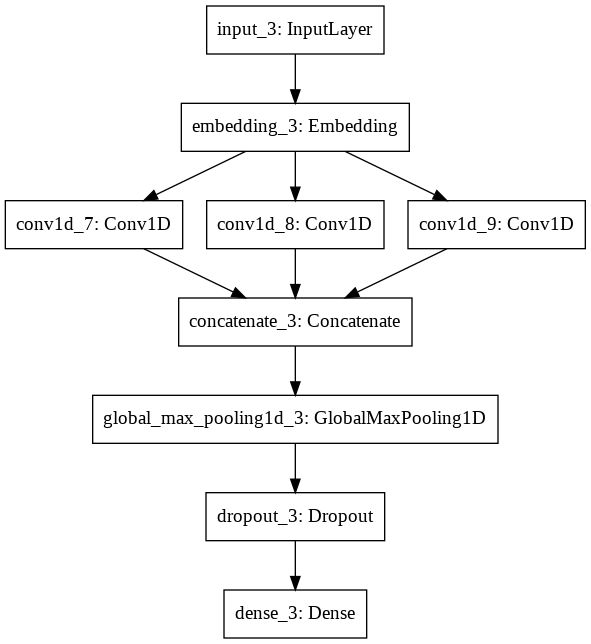

In [35]:
plot_model(model)

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
history=model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=5, batch_size=64, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 27s 1ms/step - loss: 0.4575 - acc: 0.7735 - val_loss: 0.2988 - val_acc: 0.8780
Epoch 2/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2295 - acc: 0.9090 - val_loss: 0.2629 - val_acc: 0.8950
Epoch 3/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1308 - acc: 0.9553 - val_loss: 0.2757 - val_acc: 0.8970
Epoch 4/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.0670 - acc: 0.9805 - val_loss: 0.3261 - val_acc: 0.8902
Epoch 5/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.0294 - acc: 0.9931 - val_loss: 0.3725 - val_acc: 0.8880


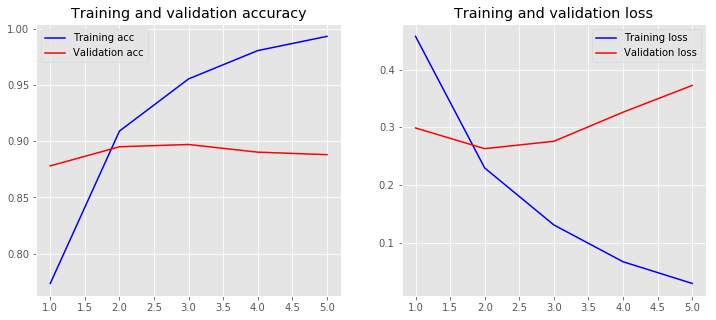

In [38]:
plot_history(history)


In [39]:
# The modle's accuracy on both training and testing sets
loss, accuracy = model.evaluate(X_val, y_val, verbose=True)
print("Training Accuracy:  {:.4f}\n".format(accuracy))

loss, accuracy = model.evaluate(X_test, labels, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

5000/5000 [==============================] - 2s 386us/step
Training Accuracy:  0.8880

25000/25000 [==============================] - 10s 388us/step
Testing Accuracy:  0.8774


In [40]:
# The final modle 
from keras.utils import plot_model
from keras.layers import Input,Embedding,Conv1D,concatenate,GlobalMaxPooling1D
from keras.layers import Dropout,Dense
from keras.models import Model
from keras import regularizers


start=Input(shape=(sent_size,))
embd=Embedding(vocb_size,100)(start)

cnv1=Conv1D(128,3, padding='same' ,activation='relu')(embd)
cnv2=Conv1D(128,4, padding='same' ,activation='relu')(embd)
cnv3=Conv1D(128,5, padding='same' ,activation='relu')(embd)


mrg = concatenate([cnv1,cnv2, cnv3])

mrg=GlobalMaxPooling1D()(mrg)
mrg= Dropout(0.2)(mrg)
# mrg=Dense(10, activation='relu')(mrg)
# mrg= Dropout(0.4)(mrg)


out=Dense(1, activation='sigmoid')(mrg)
model = Model(start,out)
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 800)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 800, 100)     1000000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 800, 128)     38528       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 800, 128)     51328       embedding_4[0][0]                
____________________________________________________________________________________________

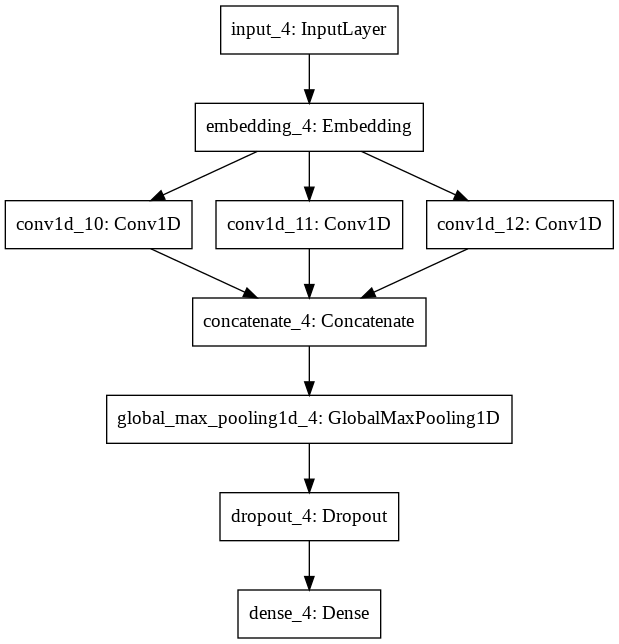

In [50]:
plot_model(model)

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
history=model.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=2, batch_size=64, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 21s 1ms/step - loss: 0.4573 - acc: 0.7741 - val_loss: 0.2982 - val_acc: 0.8730
Epoch 2/2
20000/20000 [==============================] - 20s 1ms/step - loss: 0.2305 - acc: 0.9088 - val_loss: 0.2497 - val_acc: 0.8982


In [43]:
# Final modle's accuracy for training and testing sets

loss, accuracy = model.evaluate(X_val, y_val, verbose=True)
print("Training Accuracy:  {:.4f}\n".format(accuracy))

loss, accuracy = model.evaluate(X_test, labels, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

5000/5000 [==============================] - 2s 314us/step
Training Accuracy:  0.8982

25000/25000 [==============================] - 8s 314us/step
Testing Accuracy:  0.8938


In [0]:
# extractin the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred=model.predict(X_test)
pre=[1 if i>0.5 else 0 for i in y_pred]

# #con_mat = tf.math.confusion_matrix(labels=labels, predictions= np.argmax(y_pred,axis=1)).numpy()
matrix =confusion_matrix(labels, pre)

In [45]:
matrix

array([[11291,  1209],
       [ 1445, 11055]])

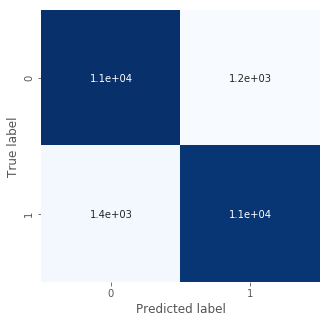

In [46]:
import seaborn as sns
figure = plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues, cbar=False)
#plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
# Loading and testing the Joker's 2019 movie
joker=[]
for line in open('/content/drive/My Drive/joker.txt','r'):
  joker.append(line.strip())

joker

["Tries too hard to be edgy, takes itself too serious. In result becomes largely pretentious and not nearly as original, smart and subversive as it tries to be. It has teenage sort of angst, self0 importance and pseudo profound darkness. Will make many believe it's deep, intellectual, complicated work of art so they are therefore nonconformist connoisseurs for liking it with subtle insight in psychology and society inner workings. Quite superficial and doesn't have much meaningful things to say, it's hollow and soulless, feels contrived rather than authentic commentary on our times, lacks something real and human. Nothing brave or revelatory here either, this story had been told before. A misunderstood tortured antihero against the cruel clown world that slights him. Tries to be a cautionary tale but at the same time it's a glorified power fantasy. Joker transforms from pathetic to crazy badass empowering himself while enacting revenge and gaining notoriety for it. The issues are portr

In [48]:
tag=[0 if i<5 else 1 for i in range(len(joker))]
joker_tok =tokenize(joker,sent_size)

loss, accuracy = model.evaluate(joker_tok, tag, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

10/10 [==============================] - 0s 576us/step
Testing Accuracy:  0.9000


In [49]:
jokerpred=model.predict(joker_tok)
pred=[1 if i>0.5 else 0 for i in jokerpred]
for i in range(len(pred)):
    if pred[i]!=tag[i]:
        print(joker[i],tag[i])


I don't see how that highly intelligent Joker on Dark Night started from this insane person. The Joker on The Dark Night is a highly intelligent person who holds deep conversations with prominent people, capable of planning a complicated bank robbery and was one step ahead of Batman, the police and intelligence. He has a strong personality free from emotionality and he laughed controllably. I can't see how this mentally unstable person on this Joker becomes that awesome Joker. 0


In [58]:
with open('/content/drive/My Drive/listfile.txt','r') as f:
  logistic=[int(i)  for i in f]
len(logistic)

25000

In [61]:
a,b,c,d=0,0,0,0
for i in range(25000):
    if pre[i]==1 and logistic[i]==1:
        a+=1
    if pre[i]==1 and logistic[i]==0:
        b+=1        
    if pre[i]==0 and logistic[i]==1:
        c+=1
    if pre[i]==0 and logistic[i]==0:
        d+=1
a,b,c,d        

(10645, 1619, 11037, 1699)

In [65]:
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[a, b],
		 [c, d]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=1619.000, p-value=0.000
Different proportions of errors (reject H0)
